In [101]:
# Imports and setup
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Reproducibility
rng = np.random.default_rng(42)
torch.manual_seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [102]:

n_samples = 1000
# mX+b
# m=0.2
# X ~ N(0,1)
# b = 0.1
X = np.linspace(-1, 1, n_samples) # note, 1000 samples as a timeseries
y = 0.2 * X + 0.1

samples = np.array([X, y]).T

In [103]:
samples.shape

(1000, 2)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(samples[:, 0], samples[:, 1], test_size=0.2, random_state=42, shuffle=False)
# SHUFFLE = FALSE. This line will accidentally introduce a time series split. Now, the model can only extrapolate on test data.
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [105]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [106]:
#data loaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Shuffle the data for better training

In [107]:
# Simple nn
class FC_ANN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

model = FC_ANN(32).to(device) # Just a single layer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train(model, criterion, optimizer, train_loader):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0) # batch
    return total_loss / len(train_loader.dataset) # per sample error


In [108]:
# Train and evaluate
n_epochs = 100
best_val = float('inf')
for epoch in range(1, n_epochs + 1):
    train_loss = train(model, criterion, optimizer, train_loader)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | train MSE: {train_loss:.4f}")

Epoch 01 | train MSE: 1.5789
Epoch 05 | train MSE: 0.1539
Epoch 10 | train MSE: 0.0055
Epoch 15 | train MSE: 0.0027
Epoch 20 | train MSE: 0.0015
Epoch 25 | train MSE: 0.0010
Epoch 30 | train MSE: 0.0008
Epoch 35 | train MSE: 0.0006
Epoch 40 | train MSE: 0.0005
Epoch 45 | train MSE: 0.0003
Epoch 50 | train MSE: 0.0003
Epoch 55 | train MSE: 0.0002
Epoch 60 | train MSE: 0.0002
Epoch 65 | train MSE: 0.0001
Epoch 70 | train MSE: 0.0001
Epoch 75 | train MSE: 0.0001
Epoch 80 | train MSE: 0.0001
Epoch 85 | train MSE: 0.0001
Epoch 90 | train MSE: 0.0001
Epoch 95 | train MSE: 0.0001
Epoch 100 | train MSE: 0.0001


In [109]:
#get test predictions from X_test
y_preds = []

for xb in X_test:
    xb = torch.tensor(xb, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(xb)
    y_preds.append(pred.cpu().numpy())

y_preds = np.array(y_preds)

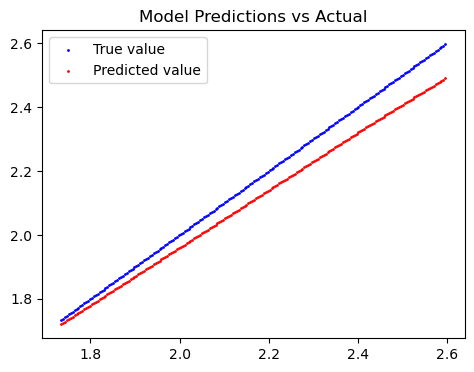

In [ ]:
# Plot test data
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.title("Model Predictions vs Actual")
plt.scatter(X_test, y_test, color='b', s=1, label="True value")
plt.scatter(X_test, y_preds, color='r', s=1, label="Predicted value")
plt.legend()
plt.show()

# As we get further outside our domain, the model's predictions become less reliable.
# w.r.t. recurrent models, they accumulate errors faster due to multiple readings of the same value.